In [1]:
import time
from copy import deepcopy
import numpy as np
import torch
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score
from dhg import Hypergraph
from dhg.data import *
from dhg.models import HGNN, UniGIN, UniSAGE, UniGAT, UniGCN
from dhg.random import set_seed
from sklearn.model_selection import train_test_split
from dhg.metrics import HypergraphVertexClassificationEvaluator as Evaluator

/users/Min/miniconda/envs/hyper/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### HGNN on CocitationCora Dataset

In [2]:
cora_data = CocitationCora()
G = Hypergraph(cora_data["num_vertices"], cora_data["edge_list"])
print(G)
# train_mask = cora_data["train_mask"]
# val_mask = cora_data["val_mask"]
# test_mask = cora_data["test_mask"]

# # 设置随机种子，以确保结果可复现
random_seed = 42

node_idx = [i for i in range(cora_data['num_vertices'])]
# 将idx_test划分为训练（50%）、验证（25%）和测试（25%）集
idx_train, idx_temp = train_test_split(node_idx, test_size=0.5, random_state=random_seed)
idx_val, idx_test = train_test_split(idx_temp, test_size=0.5, random_state=random_seed)

# 确保划分后的集合没有重叠
assert len(set(idx_train) & set(idx_val)) == 0
assert len(set(idx_train) & set(idx_test)) == 0
assert len(set(idx_val) & set(idx_test)) == 0

train_mask = torch.zeros(cora_data['num_vertices'], dtype=torch.bool)
val_mask = torch.zeros(cora_data['num_vertices'], dtype=torch.bool)
test_mask = torch.zeros(cora_data['num_vertices'], dtype=torch.bool)
train_mask[idx_train] = True
val_mask[idx_val] = True
test_mask[idx_test] = True

# idx_train = np.where(train_mask)[0]
# idx_val = np.where(val_mask)[0]
# idx_test = np.where(test_mask)[0]

X = cora_data["features"]
lbls = cora_data["labels"]
print('X dim:', X.shape)
print('labels:', len(torch.unique(lbls)))


device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

Hypergraph(num_v=2708, num_e=1483)
X dim: torch.Size([2708, 1433])
labels: 7


In [3]:

A = G.H @ G.H.T
# print(A)

# 将稀疏张量转换为标准的邻接矩阵表示
adj_matrix = torch.sparse_coo_tensor(A.indices(), A.values(), A.size())

# 计算每个节点的度
degree_list = adj_matrix.to_dense().sum(dim=1)
degree_list = degree_list.cpu().numpy().tolist()
degree_list

[9.0,
 0.0,
 0.0,
 14.0,
 2.0,
 0.0,
 0.0,
 0.0,
 5.0,
 0.0,
 0.0,
 0.0,
 2.0,
 4.0,
 36.0,
 26.0,
 0.0,
 0.0,
 11.0,
 3.0,
 4.0,
 0.0,
 10.0,
 0.0,
 0.0,
 19.0,
 0.0,
 0.0,
 0.0,
 0.0,
 11.0,
 0.0,
 2.0,
 4.0,
 0.0,
 5.0,
 13.0,
 5.0,
 7.0,
 5.0,
 0.0,
 34.0,
 5.0,
 3.0,
 0.0,
 4.0,
 8.0,
 0.0,
 5.0,
 0.0,
 0.0,
 0.0,
 8.0,
 0.0,
 0.0,
 13.0,
 0.0,
 5.0,
 9.0,
 15.0,
 10.0,
 0.0,
 18.0,
 10.0,
 3.0,
 0.0,
 52.0,
 0.0,
 21.0,
 0.0,
 26.0,
 24.0,
 8.0,
 0.0,
 108.0,
 21.0,
 46.0,
 4.0,
 6.0,
 0.0,
 0.0,
 0.0,
 23.0,
 0.0,
 20.0,
 4.0,
 6.0,
 6.0,
 13.0,
 0.0,
 4.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 18.0,
 10.0,
 6.0,
 21.0,
 0.0,
 0.0,
 0.0,
 0.0,
 17.0,
 10.0,
 44.0,
 0.0,
 0.0,
 0.0,
 0.0,
 2.0,
 2.0,
 0.0,
 0.0,
 0.0,
 0.0,
 3.0,
 7.0,
 17.0,
 2.0,
 4.0,
 7.0,
 6.0,
 8.0,
 5.0,
 36.0,
 0.0,
 0.0,
 3.0,
 3.0,
 7.0,
 0.0,
 43.0,
 15.0,
 20.0,
 0.0,
 5.0,
 0.0,
 23.0,
 11.0,
 7.0,
 20.0,
 0.0,
 0.0,
 0.0,
 0.0,
 7.0,
 0.0,
 2.0,
 0.0,
 0.0,
 4.0,
 0.0,
 66.0,
 15.0,
 10.0

In [6]:
if 1.0 in degree_list:
    print('yes')
else:
    print('no')

no


In [3]:
print('train:val:test',len(idx_train),len(idx_val),len(idx_test))

train:val:test 1354 677 677


Epoch: 0, LR: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    lr: 0.85
    maximize: False
    weight_decay: 0.0005
), Loss: 2.05129, Val Loss: 2.05129, Validation Accuracy: 0.2171344165435746
update best: 0.21713
Epoch: 1, LR: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    lr: 0.85
    maximize: False
    weight_decay: 0.0005
), Loss: 1.91559, Val Loss: 1.91559, Validation Accuracy: 0.29098966026587886
update best: 0.29099
Epoch: 2, LR: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    lr: 0.85
    maximize: False
    weight_decay: 0.0005
), Loss: 1.78390, Val Loss: 1.78390, Validation Accuracy: 0.23190546528803546
Epoch: 3, L

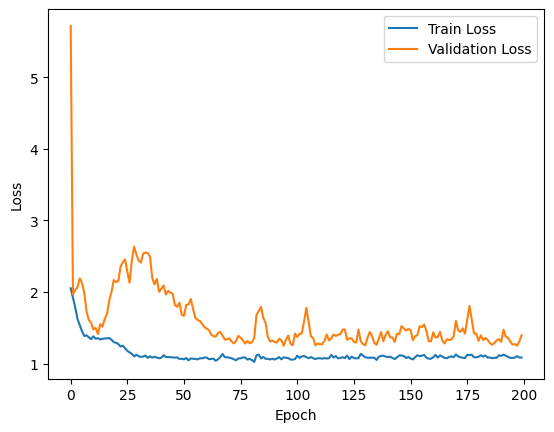

test...
Test Accuracy: 0.48892171344165436
Micro F1: 0.48892171344165436
Macro F1: 0.5142294993247528
Epoch: 0, LR: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    lr: 0.85
    maximize: False
    weight_decay: 0.0005
), Loss: 1.06586, Val Loss: 1.06586, Validation Accuracy: 0.48892171344165436
Epoch: 1, LR: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    lr: 0.85
    maximize: False
    weight_decay: 0.0005
), Loss: 1.13072, Val Loss: 1.13072, Validation Accuracy: 0.48892171344165436
Epoch: 2, LR: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    lr: 0.85
    maximize: False
    weight_decay: 0.0005
), Loss: 1.08251, Val Loss: 

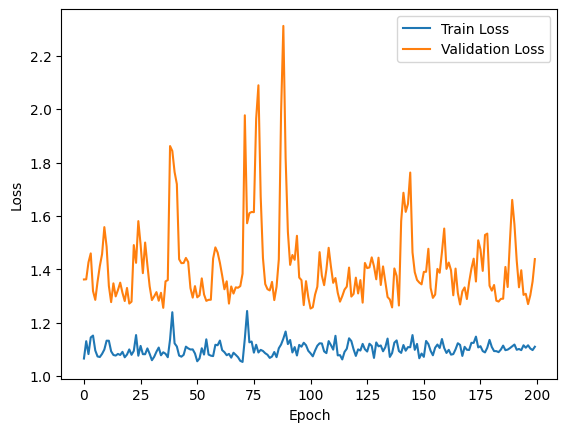

test...
Test Accuracy: 0.48892171344165436
Micro F1: 0.48892171344165436
Macro F1: 0.5142294993247528
Epoch: 0, LR: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    lr: 0.85
    maximize: False
    weight_decay: 0.0005
), Loss: 1.06219, Val Loss: 1.06219, Validation Accuracy: 0.4756277695716396
Epoch: 1, LR: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    lr: 0.85
    maximize: False
    weight_decay: 0.0005
), Loss: 1.17663, Val Loss: 1.17663, Validation Accuracy: 0.4771048744460857
Epoch: 2, LR: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    lr: 0.85
    maximize: False
    weight_decay: 0.0005
), Loss: 1.15371, Val Loss: 1.

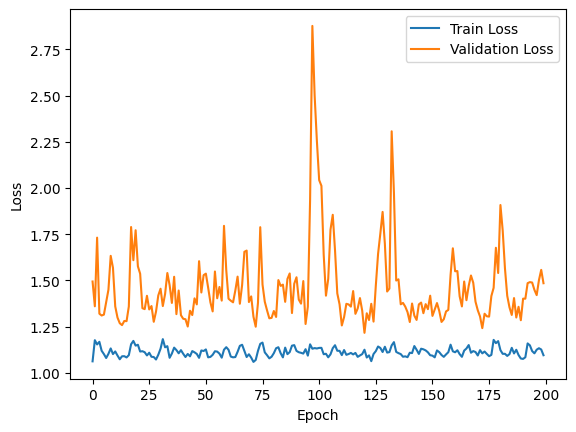

test...
Test Accuracy: 0.47858197932053176
Micro F1: 0.47858197932053176
Macro F1: 0.49027982154670297
Epoch: 0, LR: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    lr: 0.85
    maximize: False
    weight_decay: 0.0005
), Loss: 1.08747, Val Loss: 1.08747, Validation Accuracy: 0.4741506646971935
Epoch: 1, LR: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    lr: 0.85
    maximize: False
    weight_decay: 0.0005
), Loss: 1.06986, Val Loss: 1.06986, Validation Accuracy: 0.4608567208271787
Epoch: 2, LR: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    lr: 0.85
    maximize: False
    weight_decay: 0.0005
), Loss: 1.15999, Val Loss: 1

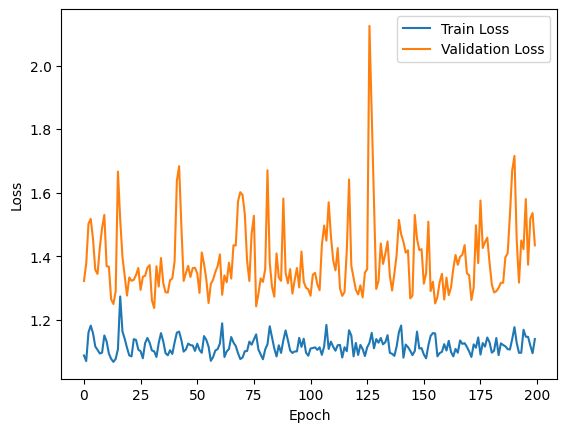

test...
Test Accuracy: 0.47858197932053176
Micro F1: 0.47858197932053176
Macro F1: 0.49027982154670297
Epoch: 0, LR: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    lr: 0.85
    maximize: False
    weight_decay: 0.0005
), Loss: 1.08396, Val Loss: 1.08396, Validation Accuracy: 0.4756277695716396
Epoch: 1, LR: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    lr: 0.85
    maximize: False
    weight_decay: 0.0005
), Loss: 1.11269, Val Loss: 1.11269, Validation Accuracy: 0.4549483013293944
Epoch: 2, LR: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    lr: 0.85
    maximize: False
    weight_decay: 0.0005
), Loss: 1.19801, Val Loss: 1

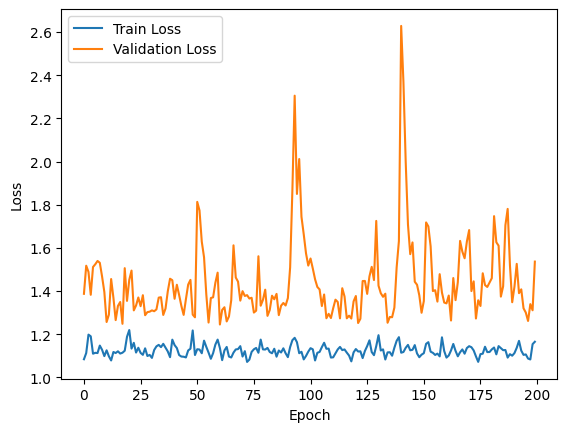

test...
Test Accuracy: 0.47858197932053176
Micro F1: 0.47858197932053176
Macro F1: 0.49027982154670297
test acc: 0.48271787296898083 test acc std: 0.00506541453455901


test microf1: 0.48271787296898083 test macrof1: 0.49985969265792285


In [112]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score

set_seed(42)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
evaluator = Evaluator(["accuracy", "f1_score", {"f1_score": {"average": "micro"}}])

net = HGNN(X.shape[1], 256, cora_data["num_classes"], use_bn=True)
optimizer = optim.Adam(net.parameters(), lr=0.85, weight_decay=5e-4)

X, lbls = X.to(device), lbls.to(device)
G = G.to(device)
net = net.to(device)

best_state = None
best_epoch, best_val = 0, 0
num_epochs = 200
all_acc, all_microf1, all_macrof1 = [],[],[]
for run in range(5):

    train_losses = []  # 新增：用于存储每个epoch的train_loss
    val_losses = []  # 新增：用于存储每个epoch的val_loss
    for epoch in range(num_epochs):
        # train
        net.train()
        optimizer.zero_grad()
        outs = net(X,G)
        outs, lbl = outs[idx_train], lbls[idx_train]
        loss = F.cross_entropy(outs, lbl)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        # validation
        net.eval()
        with torch.no_grad():
            outs = net(X,G)
            outs, lbl = outs[idx_val], lbls[idx_val]
            val_loss = F.cross_entropy(outs, lbl)
            val_losses.append(val_loss)  # 新增：记录val_loss

            _, predicted = torch.max(outs, 1)
            correct = (predicted == lbl).sum().item()
            total = lbl.size(0)
            val_acc = correct / total
            print(f"Epoch: {epoch}, LR: {optimizer}, Loss: {loss.item():.5f}, Val Loss: {loss.item():.5f}, Validation Accuracy: {val_acc}")
            

            # Save the model if it has the best validation accuracy
            if val_acc > best_val:
                print(f"update best: {val_acc:.5f}")
                best_val = val_acc
                best_state = deepcopy(net.state_dict())
                torch.save(net.state_dict(), 'hgnn_cocitationcora_best_model.pth')

    print("\ntrain finished!")
    print(f"best val: {best_val:.5f}")

    # 绘制曲线图
    plt.plot(range(num_epochs), train_losses, label='Train Loss')
    plt.plot(range(num_epochs), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # test
    print("test...")
    net.load_state_dict(best_state)

    net.eval()
    with torch.no_grad():
        outs = net(X, G)
        outs, lbl = outs[idx_test], lbls[idx_test]

        # Calculate accuracy
        _, predicted = torch.max(outs, 1)
        correct = (predicted == lbl).sum().item()
        total = lbl.size(0)
        test_acc = correct / total
        print(f'Test Accuracy: {test_acc}')

        # Calculate micro F1
        micro_f1 = f1_score(lbl.cpu(), predicted.cpu(), average='micro')
        print(f'Micro F1: {micro_f1}')

        # Calculate macro F1
        macro_f1 = f1_score(lbl.cpu(), predicted.cpu(), average='macro')
        print(f'Macro F1: {macro_f1}')

    all_acc.append(test_acc)
    all_microf1.append(micro_f1)
    all_macrof1.append(macro_f1)

# avg of 5 times
print('test acc:', np.mean(all_acc), 'test acc std:', np.std(all_acc))
print('\n')
print('test microf1:', np.mean(all_microf1), 'test macrof1:', np.mean(all_macrof1))

#### HyperGCN on CocitationCora Dataset

In [4]:
import torch
import AllSet.src.utils
from AllSet.src.utils import *
import torch.nn as nn
import torch.nn.functional as F

from torch_geometric.nn.conv import MessagePassing, GCNConv, GATConv
from AllSet.src.layers import *

import math 

from torch_scatter import scatter
from torch_geometric.utils import softmax

/users/Min/HyperGCL/src/AllSet/src/layers.py:568: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if not (normalization.__class__.__name__ is 'Identity'):
/users/Min/HyperGCL/src/AllSet/src/layers.py:617: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if not (self.f_enc.__class__.__name__ is 'Identity'):
/users/Min/HyperGCL/src/AllSet/src/layers.py:619: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if not (self.f_dec.__class__.__name__ is 'Identity'):


In [5]:
list(cora_data['edge_list'][0])

[163, 219, 538]

In [6]:
num_hes = len(cora_data['edge_list'])
he_idx = [i for i in range(num_hes)]
He_dict = dict(zip(he_idx, list(cora_data['edge_list'][i] for i in range(num_hes))))
He_dict

{0: (163, 219, 538),
 1: (163, 1114),
 2: (163, 427, 881, 2667),
 3: (163, 343, 427, 1303, 1305),
 4: (163, 1136),
 5: (163, 566, 1206),
 6: (163, 523, 1409, 2220),
 7: (129, 163, 1719, 1969, 2165),
 8: (55, 163, 1834),
 9: (100, 163, 1153, 1379, 1380),
 10: (163, 188, 1184),
 11: (163, 2490),
 12: (163, 793, 1016, 1728, 1729),
 13: (163, 501, 503, 2409),
 14: (145, 163, 2164, 2529),
 15: (163, 430, 582, 2067),
 16: (163, 1153),
 17: (163, 793, 1130, 1696),
 18: (163, 1523),
 19: (163, 727, 1424, 2205),
 20: (163, 1696, 1936),
 21: (163, 743, 744, 2030),
 22: (163, 764),
 23: (163, 846, 1184, 1533),
 24: (163, 934),
 25: (163, 1153),
 26: (163, 910, 965),
 27: (163, 793, 1249, 1592, 1715),
 28: (163, 1257, 1696, 1771),
 29: (145, 163, 2280),
 30: (145, 163),
 31: (163, 941, 1380, 1441),
 32: (163, 1136, 1796, 1946),
 33: (163, 2237),
 34: (163, 2298),
 35: (163, 537),
 36: (163, 1136),
 37: (163, 1136, 1305),
 38: (163, 793, 1016, 1153),
 39: (163, 1136),
 40: (163, 793, 1016, 1153),
 

In [7]:
V = X.shape[0]
num_features = X.shape[1]
num_layers = 2
num_classes = len(torch.unique(lbls))

print('V:', V)
print('num_feats:', num_features, 'num_layers:', num_layers, 'num_classes:', num_classes)

V: 2708
num_feats: 1433 num_layers: 2 num_classes: 7


In [8]:
HyperGCN_fast = False
HyperGCN_mediators = False
dname = 'cora'
dropout = 0.5
lbls = cora_data["labels"]

In [9]:
device

device(type='cpu')

In [10]:
class HyperGCN(nn.Module):
    def __init__(self, V, E, X, num_features, num_layers, num_classses):
        """
        d: initial node-feature dimension
        h: number of hidden units
        c: number of classes
        """
        super(HyperGCN, self).__init__()
        d, l, c = num_features, num_layers, num_classses
        # cuda = args.cuda  # and torch.cuda.is_available()

        h = [d]
        for i in range(l-1):
            power = l - i + 2
            if dname == 'citeseer':
                power = l - i + 4
            h.append(2**power)
        h.append(c)

        if HyperGCN_fast:
            reapproximate = False
            structure = AllSet.src.utils.Laplacian(V, E, X, HyperGCN_mediators)
        else:
            reapproximate = True
            structure = E

        self.layers = nn.ModuleList([AllSet.src.utils.HyperGraphConvolution(
            h[i], h[i+1], reapproximate) for i in range(l)])
        self.do, self.l = dropout, num_layers
        self.structure, self.m = structure, HyperGCN_mediators

    def reset_parameters(self):
        for layer in self.layers:
            layer.reset_parameters()

    def forward(self, X):
        """
        an l-layer GCN
        """
        do, l, m = self.do, self.l, self.m
        H = X

        for i, hidden in enumerate(self.layers):
            H = F.relu(hidden(self.structure, H, m))
            if i < l - 1:
                V = H
                H = F.dropout(H, do, training=self.training)

        return H

In [11]:
model_hypergcn = HyperGCN(V, He_dict, X, num_features, num_layers, num_classes)
optimizer = optim.Adam(model_hypergcn.parameters(),lr=0.01,weight_decay=5e-4)
model_hypergcn = model_hypergcn.to(device)
# V = V.to(device)
# He_dict = He_dict.to(device)
# num_features = num_features.to(device)
# num_layers = num_layers.to(device)
# num_classes = num_classes.to(device)

Epoch: 0, Time: 0.66061s, Loss: 1.91443
Epoch: 0, Loss: 1.91443, Val Loss: 1.91443, Validation Accuracy: 0.1329394387001477
update best: 0.13294
Epoch: 1, Time: 0.11782s, Loss: 1.91629
Epoch: 1, Loss: 1.91629, Val Loss: 1.91629, Validation Accuracy: 0.13146233382570163
Epoch: 2, Time: 0.08900s, Loss: 1.91807
Epoch: 2, Loss: 1.91807, Val Loss: 1.91807, Validation Accuracy: 0.1358936484490399
update best: 0.13589
Epoch: 3, Time: 0.13779s, Loss: 1.91986
Epoch: 3, Loss: 1.91986, Val Loss: 1.91986, Validation Accuracy: 0.1344165435745938
Epoch: 4, Time: 0.20077s, Loss: 1.91437
Epoch: 4, Loss: 1.91437, Val Loss: 1.91437, Validation Accuracy: 0.1344165435745938
Epoch: 5, Time: 0.10075s, Loss: 1.91825
Epoch: 5, Loss: 1.91825, Val Loss: 1.91825, Validation Accuracy: 0.1344165435745938
Epoch: 6, Time: 0.13279s, Loss: 1.91727
Epoch: 6, Loss: 1.91727, Val Loss: 1.91727, Validation Accuracy: 0.13737075332348597
update best: 0.13737
Epoch: 7, Time: 0.04803s, Loss: 1.91346
Epoch: 7, Loss: 1.91346, Va

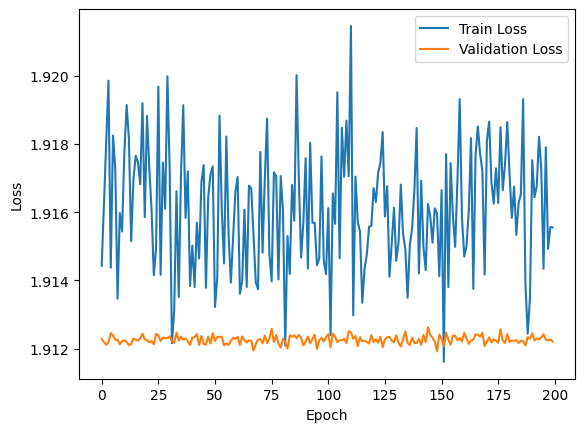

test...
Test Accuracy: 0.1358936484490399
Micro F1: 0.1358936484490399
Macro F1: 0.04282485021012039
Epoch: 0, Time: 0.06519s, Loss: 1.91501
Epoch: 0, Loss: 1.91501, Val Loss: 1.91501, Validation Accuracy: 0.1344165435745938
Epoch: 1, Time: 0.06539s, Loss: 1.91641
Epoch: 1, Loss: 1.91641, Val Loss: 1.91641, Validation Accuracy: 0.1344165435745938
Epoch: 2, Time: 0.05955s, Loss: 1.91685
Epoch: 2, Loss: 1.91685, Val Loss: 1.91685, Validation Accuracy: 0.1344165435745938
Epoch: 3, Time: 0.05670s, Loss: 1.91677
Epoch: 3, Loss: 1.91677, Val Loss: 1.91677, Validation Accuracy: 0.13146233382570163
Epoch: 4, Time: 0.05688s, Loss: 1.91472
Epoch: 4, Loss: 1.91472, Val Loss: 1.91472, Validation Accuracy: 0.1344165435745938
Epoch: 5, Time: 0.05719s, Loss: 1.91266
Epoch: 5, Loss: 1.91266, Val Loss: 1.91266, Validation Accuracy: 0.1358936484490399
Epoch: 6, Time: 0.23942s, Loss: 1.91908
Epoch: 6, Loss: 1.91908, Val Loss: 1.91908, Validation Accuracy: 0.1344165435745938
Epoch: 7, Time: 0.05343s, Loss

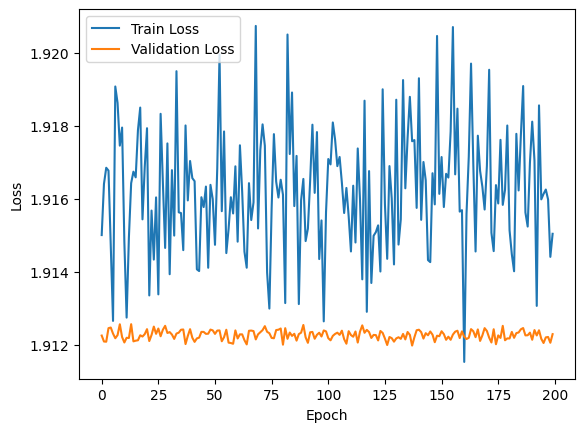

test...
Test Accuracy: 0.1358936484490399
Micro F1: 0.1358936484490399
Macro F1: 0.04282485021012039
Epoch: 0, Time: 0.04057s, Loss: 1.91743
Epoch: 0, Loss: 1.91743, Val Loss: 1.91743, Validation Accuracy: 0.1344165435745938
Epoch: 1, Time: 0.04107s, Loss: 1.91590
Epoch: 1, Loss: 1.91590, Val Loss: 1.91590, Validation Accuracy: 0.1344165435745938
Epoch: 2, Time: 0.10470s, Loss: 1.91388
Epoch: 2, Loss: 1.91388, Val Loss: 1.91388, Validation Accuracy: 0.1344165435745938
Epoch: 3, Time: 0.04265s, Loss: 1.91650
Epoch: 3, Loss: 1.91650, Val Loss: 1.91650, Validation Accuracy: 0.1329394387001477
Epoch: 4, Time: 0.04440s, Loss: 1.91693
Epoch: 4, Loss: 1.91693, Val Loss: 1.91693, Validation Accuracy: 0.1358936484490399
Epoch: 5, Time: 0.04393s, Loss: 1.91900
Epoch: 5, Loss: 1.91900, Val Loss: 1.91900, Validation Accuracy: 0.1344165435745938
Epoch: 6, Time: 0.04201s, Loss: 1.91387
Epoch: 6, Loss: 1.91387, Val Loss: 1.91387, Validation Accuracy: 0.1344165435745938
Epoch: 7, Time: 0.05983s, Loss:

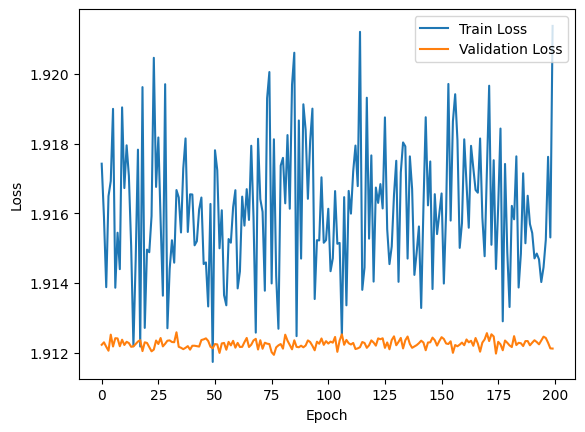

test...
Test Accuracy: 0.13884785819793205
Micro F1: 0.13884785819793205
Macro F1: 0.044554530075205365
Epoch: 0, Time: 0.05764s, Loss: 1.91636
Epoch: 0, Loss: 1.91636, Val Loss: 1.91636, Validation Accuracy: 0.1329394387001477
Epoch: 1, Time: 0.06844s, Loss: 1.91355
Epoch: 1, Loss: 1.91355, Val Loss: 1.91355, Validation Accuracy: 0.1358936484490399
Epoch: 2, Time: 0.06300s, Loss: 1.91415
Epoch: 2, Loss: 1.91415, Val Loss: 1.91415, Validation Accuracy: 0.1344165435745938
Epoch: 3, Time: 0.06051s, Loss: 1.91648
Epoch: 3, Loss: 1.91648, Val Loss: 1.91648, Validation Accuracy: 0.1329394387001477
Epoch: 4, Time: 0.06043s, Loss: 1.91336
Epoch: 4, Loss: 1.91336, Val Loss: 1.91336, Validation Accuracy: 0.1358936484490399
Epoch: 5, Time: 0.06072s, Loss: 1.91312
Epoch: 5, Loss: 1.91312, Val Loss: 1.91312, Validation Accuracy: 0.1358936484490399
Epoch: 6, Time: 0.05678s, Loss: 1.91604
Epoch: 6, Loss: 1.91604, Val Loss: 1.91604, Validation Accuracy: 0.1329394387001477
Epoch: 7, Time: 0.06267s, Lo

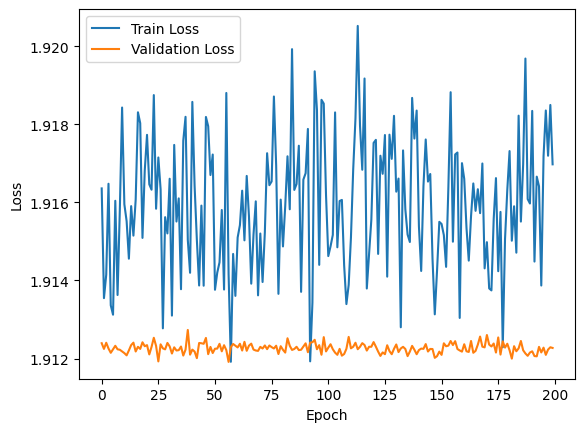

test...
Test Accuracy: 0.1358936484490399
Micro F1: 0.1358936484490399
Macro F1: 0.04282485021012039
Epoch: 0, Time: 0.06354s, Loss: 1.91563
Epoch: 0, Loss: 1.91563, Val Loss: 1.91563, Validation Accuracy: 0.1344165435745938
Epoch: 1, Time: 0.06297s, Loss: 1.91542
Epoch: 1, Loss: 1.91542, Val Loss: 1.91542, Validation Accuracy: 0.1344165435745938
Epoch: 2, Time: 0.05716s, Loss: 1.91332
Epoch: 2, Loss: 1.91332, Val Loss: 1.91332, Validation Accuracy: 0.1329394387001477
Epoch: 3, Time: 0.05627s, Loss: 1.91531
Epoch: 3, Loss: 1.91531, Val Loss: 1.91531, Validation Accuracy: 0.1358936484490399
Epoch: 4, Time: 0.05487s, Loss: 1.91734
Epoch: 4, Loss: 1.91734, Val Loss: 1.91734, Validation Accuracy: 0.1344165435745938
Epoch: 5, Time: 0.05900s, Loss: 1.91814
Epoch: 5, Loss: 1.91814, Val Loss: 1.91814, Validation Accuracy: 0.1329394387001477
Epoch: 6, Time: 0.05839s, Loss: 1.91345
Epoch: 6, Loss: 1.91345, Val Loss: 1.91345, Validation Accuracy: 0.1344165435745938
Epoch: 7, Time: 0.05263s, Loss:

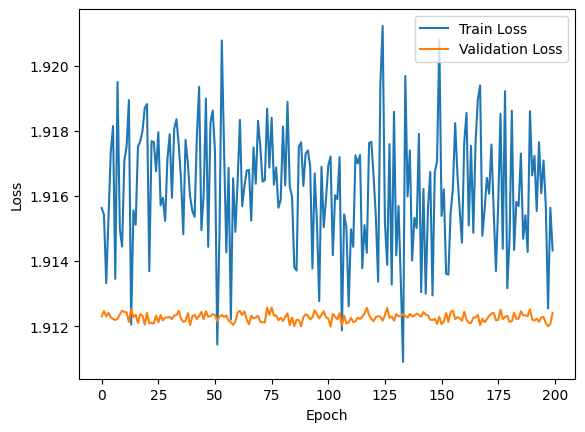

test...
Test Accuracy: 0.1358936484490399
Micro F1: 0.1358936484490399
Macro F1: 0.04286352085715972
test acc: 0.13648449039881833 test acc std: 0.0011816838995568624


test microf1: 0.13648449039881833 test macrof1: 0.04317852031254525


In [113]:
best_state = None
best_epoch, best_val = 0, 0
evaluator = Evaluator(["accuracy", "f1_score", {"f1_score": {"average": "micro"}}])

all_acc, all_microf1, all_macrof1 = [],[],[]
for run in range(5):
    train_losses = []  # 新增：用于存储每个epoch的train_loss
    val_losses = []  # 新增：用于存储每个epoch的val_loss
    for epoch in range(num_epochs):
        model_hypergcn.train()
        st = time.time()
        optimizer.zero_grad()
        outs = model_hypergcn(X)
        outs, lbl = outs[idx_train], lbls[idx_train]
        loss = F.cross_entropy(outs, lbl)
        train_losses.append(loss.item())
        loss.backward()
        optimizer.step()
        print(f"Epoch: {epoch}, Time: {time.time()-st:.5f}s, Loss: {loss.item():.5f}")

        # validation

        model_hypergcn.eval()
        with torch.no_grad():
            outs = model_hypergcn(X)
            outs, lbl = outs[idx_val], lbls[idx_val]
            val_loss = F.cross_entropy(outs, lbl)
            val_losses.append(val_loss.item())

            _, predicted = torch.max(outs, 1)
            correct = (predicted == lbl).sum().item()
            total = lbl.size(0)
            val_acc = correct / total
            print(f"Epoch: {epoch}, Loss: {loss.item():.5f}, Val Loss: {loss.item():.5f}, Validation Accuracy: {val_acc}")
            
            # Save the model if it has the best validation accuracy
            if val_acc > best_val:
                print(f"update best: {val_acc:.5f}")
                best_val = val_acc
                best_state = deepcopy(model_hypergcn.state_dict())
                torch.save(net.state_dict(), 'hypergcn_cocitationcora_best_model.pth')

    print("\ntrain finished!")
    print(f"best val: {best_val:.5f}")

    # 绘制曲线图
    plt.plot(range(num_epochs), train_losses, label='Train Loss')
    plt.plot(range(num_epochs), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    # test
    print("test...")
    model_hypergcn.load_state_dict(best_state)

    model_hypergcn.eval()
    with torch.no_grad():
        outs = model_hypergcn(X)
        outs, lbl = outs[idx_test], lbls[idx_test]

        # Calculate accuracy
        _, predicted = torch.max(outs, 1)
        correct = (predicted == lbl).sum().item()
        total = lbl.size(0)
        test_acc = correct / total
        print(f'Test Accuracy: {test_acc}')

        # Calculate micro F1
        micro_f1 = f1_score(lbl.cpu(), predicted.cpu(), average='micro')
        print(f'Micro F1: {micro_f1}')

        # Calculate macro F1
        macro_f1 = f1_score(lbl.cpu(), predicted.cpu(), average='macro')
        print(f'Macro F1: {macro_f1}')

    all_acc.append(test_acc)
    all_microf1.append(micro_f1)
    all_macrof1.append(macro_f1)


# avg of 3 times
print('test acc:', np.mean(all_acc), 'test acc std:', np.std(all_acc))
print('\n')
print('test microf1:', np.mean(all_microf1), 'test macrof1:', np.mean(all_macrof1))


        



#### HCHA on CocitationCora Dataset

In [12]:
HCHA_symdegnorm=False
MLP_hidden=64

In [13]:
from AllSet.src.layers import HypergraphConv

class HCHA(nn.Module):
    """
    This model is proposed by "Hypergraph Convolution and Hypergraph Attention" (in short HCHA) and its convolutional layer 
    is implemented in pyg.
    """

    def __init__(self, num_features, num_layers, num_classes, MLP_hidden, dropout, HCHA_symdegnorm):
        super(HCHA, self).__init__()

        self.num_layers = num_layers
        self.dropout = dropout  # Note that default is 0.6
        self.symdegnorm = HCHA_symdegnorm

#         Note that add dropout to attention is default in the original paper
        self.convs = nn.ModuleList()
        self.convs.append(HypergraphConv(num_features,
                                         MLP_hidden, self.symdegnorm))
        for _ in range(self.num_layers-2):
            self.convs.append(HypergraphConv(
                MLP_hidden, MLP_hidden, self.symdegnorm))
        # Output heads is set to 1 as default
        self.convs.append(HypergraphConv(
            MLP_hidden, num_classes, self.symdegnorm))

    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()

    def forward(self, x, edge_index):

        # x = data.x
        # edge_index = data.edge_index

        for i, conv in enumerate(self.convs[:-1]):
            x = F.elu(conv(x, edge_index))
            x = F.dropout(x, p=self.dropout, training=self.training)

#         x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.convs[-1](x, edge_index)

        return x

In [14]:
G.num_v

2708

In [15]:
def from_hypergraph_clique(
    hypergraph: "Hypergraph", weighted: bool = False, miu: float = 1.0, device: torch.device = torch.device("cpu"),
) -> "Graph":
    r"""Construct a graph from a hypergraph with clique expansion refering to `Higher Order Learning with Graphs <https://homes.cs.washington.edu/~sagarwal/holg.pdf>`_ paper.

    Args:
        ``hypergraph`` (``Hypergraph``): The source hypergraph.
        ``weighted`` (``bool``, optional): Whether to construct a weighted graph. Defaults to ``False``.
        ``miu`` (``float``, optional): The parameter of clique expansion. Defaults to ``1.0``.
        ``device`` (``torch.device``): The device to store the graph. Defaults to ``torch.device("cpu")``.
    """
    num_v = hypergraph.num_v
    miu = 1.0
    adj = miu * hypergraph.H.mm(hypergraph.H_T).coalesce().cpu().clone()
    src_idx, dst_idx = adj._indices()
    edge_mask = src_idx < dst_idx
    edge_list = torch.stack([src_idx[edge_mask], dst_idx[edge_mask]]).t().cpu().numpy().tolist()
    # if weighted:
    #     e_weight = adj._values()[edge_mask].numpy().tolist()
    #     _g = Graph(num_v, edge_list, e_weight, merge_op="sum", device=device)
    # else:
    #     _g = Graph(num_v, edge_list, merge_op="mean", device=device)
    return num_v, edge_list

In [16]:
G.e[0]

[(163, 219, 538),
 (163, 1114),
 (163, 427, 881, 2667),
 (163, 343, 427, 1303, 1305),
 (163, 1136),
 (163, 566, 1206),
 (163, 523, 1409, 2220),
 (129, 163, 1719, 1969, 2165),
 (55, 163, 1834),
 (100, 163, 1153, 1379, 1380),
 (163, 188, 1184),
 (163, 2490),
 (163, 793, 1016, 1728, 1729),
 (163, 501, 503, 2409),
 (145, 163, 2164, 2529),
 (163, 430, 582, 2067),
 (163, 1153),
 (163, 793, 1130, 1696),
 (163, 1523),
 (163, 727, 1424, 2205),
 (163, 1696, 1936),
 (163, 743, 744, 2030),
 (163, 764),
 (163, 846, 1184, 1533),
 (163, 934),
 (163, 910, 965),
 (163, 793, 1249, 1592, 1715),
 (163, 1257, 1696, 1771),
 (145, 163, 2280),
 (145, 163),
 (163, 941, 1380, 1441),
 (163, 1136, 1796, 1946),
 (163, 2237),
 (163, 2298),
 (163, 537),
 (163, 1136, 1305),
 (163, 793, 1016, 1153),
 (163, 343, 1216, 1218, 2202),
 (163, 995, 1696, 2211),
 (163, 728, 793, 938, 1153),
 (163, 343),
 (163, 168),
 (163, 523, 565, 902),
 (163, 636, 846, 2204),
 (163, 294),
 (163, 1016),
 (163, 569, 826, 828, 1462),
 (163, 1

In [17]:
import numpy as np

# 将超边列表转换为边索引的两个维度
node_list = []
he_list = []
he_id = 0
for hyperedge in G.e[0]:
    node_list += list(hyperedge)
    he_list += [he_id] * len(hyperedge)
    he_id += 1

# 计算偏移量，将节点索引从最小值开始重新映射为从0开始的连续整数
node_idx_min = np.min(node_list)
node_list = [x - node_idx_min for x in node_list]

# 构造边索引数组
edge_index = np.array([node_list, he_list])

In [18]:
edge_index.shape, X.shape, len(node_list)

((2, 4544), torch.Size([2708, 1433]), 4544)

In [19]:
edge_index = torch.LongTensor(edge_index) # 节点index-超边index
edge_index[1] -= edge_index[1].min()
edge_index, torch.max(edge_index), edge_index.shape

(tensor([[ 163,  219,  538,  ..., 1884, 1885, 1886],
         [   0,    0,    0,  ..., 1482, 1482, 1482]]),
 tensor(2707),
 torch.Size([2, 4544]))

In [20]:
X.shape, len(he_list), max(he_list)

(torch.Size([2708, 1433]), 4544, 1482)

In [21]:
import numpy as np

# 初始化超边特征列表
hyperedge_features = []

# 遍历每个超边
for hyperedge in G.e[0]:
    hyperedge = list(hyperedge) # 元组转换为列表
    # 根据超边中的节点索引获取对应的节点特征
    hyperedge_node_features = X[hyperedge,:]
    # print(hyperedge_node_features.shape)
    
    # 对节点特征进行聚合操作，例如求和、均值或最大值
    aggregated_feature = torch.sum(hyperedge_node_features, dim=0)  # 以求和为例

    
    # 将聚合后的特征添加到超边特征列表中
    hyperedge_features.append(aggregated_feature)

# 将超边特征转换为数组
hyperedge_features = np.array(hyperedge_features)
hyperedge_features.shape

(1483, 1433)

In [22]:
X_he = torch.FloatTensor(hyperedge_features)
X_he.shape

torch.Size([1483, 1433])

In [23]:
# edge_index = G.H.to_dense().to(torch.long)
# edge_index, edge_index.shape, type(edge_index)

##### 构造HCHA输入data (pyg Data 对象)

In [24]:
import numpy as np
import torch
from scipy import sparse
from torch_geometric.data import Data
from torch_sparse import coalesce

def create_pyg_data(X, H):
    # X: Node features, H: Hypergraph adjacency matrix

    # Convert X to a dense tensor
    x = torch.FloatTensor(X.to_dense())

    # Convert H to a dense tensor and then to a coo_matrix
    H_dense = H.to_dense()
    coo_H = sparse.coo_matrix(H_dense.numpy())

    # Build edge_index from COO format
    edge_index = torch.LongTensor(np.vstack((coo_H.col, coo_H.row)))

    # Create a Data object
    data = Data(x=x, edge_index=edge_index)

    # Coalesce edge_index to remove duplicates
    total_num_nodes = X.shape[0]  # get the total number of nodes
    data.edge_index, _ = coalesce(data.edge_index, None, total_num_nodes, total_num_nodes)

    return data

# Example usage:
# Assuming X is your node features and H is your hypergraph adjacency matrix
data = create_pyg_data(X, G.H)

# data = Data(x=X, edge_index=edge_index)
data

Data(x=[2708, 1433], edge_index=[2, 4544])

In [25]:
model_hcha = HCHA(num_features, num_layers, num_classes, MLP_hidden, dropout, HCHA_symdegnorm)
optimizer = optim.Adam(model_hcha.parameters(),lr=0.0005,weight_decay=5e-4)
model_hcha = model_hcha.to(device)
model_hcha

HCHA(
  (convs): ModuleList(
    (0): HypergraphConv(1433, 64)
    (1): HypergraphConv(64, 7)
  )
)

In [114]:
best_state = None
best_epoch, best_val = 0, 0
evaluator = Evaluator(["accuracy", "f1_score", {"f1_score": {"average": "micro"}}])

all_acc, all_microf1, all_macrof1 = [],[],[]
for run in range(5):
    train_losses = []  # 新增：用于存储每个epoch的train_loss
    val_losses = []  # 新增：用于存储每个epoch的val_loss
    for epoch in range(num_epochs):
        model_hcha.train()
        st = time.time()
        optimizer.zero_grad()
        outs = model_hcha(data.x, data.edge_index)
        outs, lbl = outs[idx_train], lbls[idx_train]
        
        loss = F.cross_entropy(outs, lbl)
        train_losses.append(loss.item())
        loss.backward()
        optimizer.step()
        print(f"Epoch: {epoch}, Time: {time.time()-st:.5f}s, Loss: {loss.item():.5f}")

        # validation

        model_hcha.eval()
        with torch.no_grad():
            outs = model_hcha(data.x, data.edge_index)
            
            outs, lbl = outs[idx_val], lbls[idx_val]
            val_loss = F.cross_entropy(outs, lbl)
            val_losses.append(val_loss.item())

            _, predicted = torch.max(outs, 1)
            correct = (predicted == lbl).sum().item()
            total = lbl.size(0)
            val_acc = correct / total
            print(f"Epoch: {epoch}, Loss: {loss.item():.5f}, Val Loss: {loss.item():.5f}, Validation Accuracy: {val_acc}")
            

            # Save the model if it has the best validation accuracy
            if val_acc > best_val:
                print(f"update best: {val_acc:.5f}")
                best_val = val_acc
                best_state = deepcopy(model_hcha.state_dict())
                torch.save(model_hcha.state_dict(), 'hcha_cocitationcora_best_model.pth')
        
    print("\ntrain finished!")
    print(f"best val: {best_val:.5f}")

    # 绘制曲线图
    plt.plot(range(num_epochs), train_losses, label='Train Loss')
    plt.plot(range(num_epochs), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # test
    print("test...")
    model_hcha.load_state_dict(best_state)

    model_hcha.eval()
    with torch.no_grad():
        outs = model_hcha(data.x, data.edge_index)
        outs, lbl = outs[idx_test], lbls[idx_test]

        # Calculate accuracy
        _, predicted = torch.max(outs, 1)
        correct = (predicted == lbl).sum().item()
        total = lbl.size(0)
        test_acc = correct / total
        print(f'Test Accuracy: {test_acc}')

        # Calculate micro F1
        micro_f1 = f1_score(lbl.cpu(), predicted.cpu(), average='micro')
        print(f'Micro F1: {micro_f1}')

        # Calculate macro F1
        macro_f1 = f1_score(lbl.cpu(), predicted.cpu(), average='macro')
        print(f'Macro F1: {macro_f1}')
    
    all_acc.append(test_acc)
    all_microf1.append(micro_f1)
    all_macrof1.append(macro_f1)

# avg of 5 times
print('test acc:', np.mean(all_acc), 'test acc std:', np.std(all_acc))
print('\n')
print('test microf1:', np.mean(all_microf1), 'test macrof1:', np.mean(all_macrof1))


        



/users/Min/HyperGCL/src/AllSet/src/layers.py:568: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if not (normalization.__class__.__name__ is 'Identity'):
/users/Min/HyperGCL/src/AllSet/src/layers.py:617: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if not (self.f_enc.__class__.__name__ is 'Identity'):
/users/Min/HyperGCL/src/AllSet/src/layers.py:619: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if not (self.f_dec.__class__.__name__ is 'Identity'):
/users/Min/HyperGCL/src/AllSet/src/layers.py:568: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if not (normalization.__class__.__name__ is 'Identity'):
/users/Min/HyperGCL/src/AllSet/src/layers.py:617: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if not (self.f_enc.__class__.__name__ is 'Identity'):
/users/Min/HyperGCL/src/AllSet/src/layers.py:619: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if not (self.f_dec.__class__.__name__ is 'Identity'):


ValueError: Encountered tensor with size 1483 in dimension 0, but expected size 2708.

#### ALLSet on CocitationCora Dataset

In [26]:
data = Data(x=X, edge_index=edge_index)
data

Data(x=[2708, 1433], edge_index=[2, 4544])

In [27]:
data.edge_index[1]

tensor([   0,    0,    0,  ..., 1482, 1482, 1482])

In [28]:
np.unique(data.edge_index[1])

array([   0,    1,    2, ..., 1480, 1481, 1482])

In [29]:
data.n_x = torch.tensor([data.x.shape[0]])
data.num_hyperedges = torch.tensor(
                [len(np.unique(data.edge_index[1]))])
data

Data(x=[2708, 1433], edge_index=[2, 4544], n_x=[1], num_hyperedges=[1])

In [63]:
V_in_dim, V_enc_hid_dim, V_dec_hid_dim, V_out_dim = num_features, 64, 32, 8
V_enc_num_layers, V_dec_num_layers = 2, 2
E_in_dim, E_enc_hid_dim, E_dec_hid_dim, E_out_dim = 8, 32, 64, num_classes
E_enc_num_layers, E_dec_num_layers = 2, 2


All_num_layers, MLP_num_layers, Classifier_num_layers, MLP_hidden, Classifier_hidden= 2, 2, 2, 64, 64
dropout = 0.6
heads = 1
aggregate='mean'
normalization='ln'
deepset_input_norm=True
GPR=False
LearnMask=False
PMA = True
add_self_loop=True
deepset_input_norm = True


In [64]:
data.num_hyperedges[0],data.n_x[0],data.edge_index[0].max()

(tensor(1483), tensor(2708), tensor(2707))

In [65]:
data.norm = torch.ones_like(torch.tensor(data.edge_index[0]))
data

/tmp/ipykernel_2341016/993366949.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data.norm = torch.ones_like(torch.tensor(data.edge_index[0]))


Data(x=[2708, 1433], edge_index=[2, 4544], n_x=[1], num_hyperedges=[1], norm=[4544])

In [96]:
import argparse

parser = argparse.ArgumentParser()
parser.add_argument('--train_prop', type=float, default=0.5)
parser.add_argument('--valid_prop', type=float, default=0.25)
parser.add_argument('--dname', default='cora')
# method in ['SetGNN','CEGCN','CEGAT','HyperGCN','HGNN','HCHA']
parser.add_argument('--method', default='AllSetTransformer')
parser.add_argument('--epochs', default=500, type=int)
# Number of runs for each split (test fix, only shuffle train/val)
parser.add_argument('--runs', default=20, type=int)
parser.add_argument('--cuda', default=0, choices=[-1, 0, 1], type=int)
parser.add_argument('--dropout', default=0.5, type=float)
parser.add_argument('--lr', default=0.001, type=float)
parser.add_argument('--wd', default=0.0, type=float)
# How many layers of full NLConvs
parser.add_argument('--All_num_layers', default=2, type=int)
parser.add_argument('--MLP_num_layers', default=2,
                    type=int)  # How many layers of encoder
parser.add_argument('--MLP_hidden', default=64,
                    type=int)  # Encoder hidden units
parser.add_argument('--Classifier_num_layers', default=2,
                    type=int)  # How many layers of decoder
parser.add_argument('--Classifier_hidden', default=64,
                    type=int)  # Decoder hidden units
parser.add_argument('--display_step', type=int, default=-1)
parser.add_argument('--aggregate', default='mean', choices=['sum', 'mean'])
# ['all_one','deg_half_sym']
parser.add_argument('--normtype', default='all_one')
parser.add_argument('--add_self_loop', action='store_false')
# NormLayer for MLP. ['bn','ln','None']
parser.add_argument('--normalization', default='ln')
parser.add_argument('--deepset_input_norm', default = True)
parser.add_argument('--GPR', action='store_false')  # skip all but last dec
# skip all but last dec
parser.add_argument('--LearnMask', action='store_false')
parser.add_argument('--num_features', default=1433, type=int)  # Placeholder
parser.add_argument('--num_classes', default=7, type=int)  # Placeholder
# Choose std for synthetic feature noise
parser.add_argument('--feature_noise', default='1', type=str)
# whether the he contain self node or not
parser.add_argument('--exclude_self', action='store_true')
parser.add_argument('--PMA', action='store_true')
#     Args for HyperGCN
parser.add_argument('--HyperGCN_mediators', action='store_true')
parser.add_argument('--HyperGCN_fast', action='store_true')
#     Args for Attentions: GAT and SetGNN
parser.add_argument('--heads', default=1, type=int)  # Placeholder
parser.add_argument('--output_heads', default=1, type=int)  # Placeholder
#     Args for HNHN
parser.add_argument('--HNHN_alpha', default=-1.5, type=float)
parser.add_argument('--HNHN_beta', default=-0.5, type=float)
parser.add_argument('--HNHN_nonlinear_inbetween', default=True, type=bool)
#     Args for HCHA
parser.add_argument('--HCHA_symdegnorm', action='store_true')
#     Args for UniGNN
parser.add_argument('--UniGNN_use-norm', action="store_true", help='use norm in the final layer')
parser.add_argument('--UniGNN_degV', default = 0)
parser.add_argument('--UniGNN_degE', default = 0)

parser.set_defaults(PMA=True)  # True: Use PMA. False: Use Deepsets.
parser.set_defaults(add_self_loop=True)
parser.set_defaults(exclude_self=False)
parser.set_defaults(GPR=False)
parser.set_defaults(LearnMask=False)
parser.set_defaults(HyperGCN_mediators=True)
parser.set_defaults(HyperGCN_fast=True)
parser.set_defaults(HCHA_symdegnorm=False)

args = parser.parse_args([])
args, _ = parser.parse_known_args()
print(args)

Namespace(train_prop=0.5, valid_prop=0.25, dname='cora', method='AllSetTransformer', epochs=500, runs=20, cuda=0, dropout=0.5, lr=0.001, wd=0.0, All_num_layers=2, MLP_num_layers=2, MLP_hidden=64, Classifier_num_layers=2, Classifier_hidden=64, display_step=-1, aggregate='mean', normtype='all_one', add_self_loop=True, normalization='ln', deepset_input_norm=True, GPR=False, LearnMask=False, num_features=1433, num_classes=7, feature_noise='/users/Min/.local/share/jupyter/runtime/kernel-v2-2275798qgTFDT2pfnWo.json', exclude_self=False, PMA=True, HyperGCN_mediators=True, HyperGCN_fast=True, heads=1, output_heads=1, HNHN_alpha=-1.5, HNHN_beta=-0.5, HNHN_nonlinear_inbetween=True, HCHA_symdegnorm=False, UniGNN_use_norm=False, UniGNN_degV=0, UniGNN_degE=0)


In [97]:
from AllSet.src.layers import *
from AllSet.src.models import *
from AllSet.src.utils import *

class SetGNN(nn.Module):
    def __init__(self, args, norm=None):
        super(SetGNN, self).__init__()
        """
        args should contain the following:
        V_in_dim, V_enc_hid_dim, V_dec_hid_dim, V_out_dim, V_enc_num_layers, V_dec_num_layers
        E_in_dim, E_enc_hid_dim, E_dec_hid_dim, E_out_dim, E_enc_num_layers, E_dec_num_layers
        All_num_layers,dropout
        !!! V_in_dim should be the dimension of node features
        !!! E_out_dim should be the number of classes (for classification)
        """
#         V_in_dim = V_dict['in_dim']
#         V_enc_hid_dim = V_dict['enc_hid_dim']
#         V_dec_hid_dim = V_dict['dec_hid_dim']
#         V_out_dim = V_dict['out_dim']
#         V_enc_num_layers = V_dict['enc_num_layers']
#         V_dec_num_layers = V_dict['dec_num_layers']

#         E_in_dim = E_dict['in_dim']
#         E_enc_hid_dim = E_dict['enc_hid_dim']
#         E_dec_hid_dim = E_dict['dec_hid_dim']
#         E_out_dim = E_dict['out_dim']
#         E_enc_num_layers = E_dict['enc_num_layers']
#         E_dec_num_layers = E_dict['dec_num_layers']

#         Now set all dropout the same, but can be different
        self.All_num_layers = args.All_num_layers
        self.dropout = args.dropout
        self.aggr = args.aggregate
        self.NormLayer = args.normalization
        self.InputNorm = args.deepset_input_norm
        self.GPR = args.GPR
        self.LearnMask = args.LearnMask
#         Now define V2EConvs[i], V2EConvs[i] for ith layers
#         Currently we assume there's no hyperedge features, which means V_out_dim = E_in_dim
#         If there's hyperedge features, concat with Vpart decoder output features [V_feat||E_feat]
        self.V2EConvs = nn.ModuleList()
        self.E2VConvs = nn.ModuleList()
        self.bnV2Es = nn.ModuleList()
        self.bnE2Vs = nn.ModuleList()

        if self.LearnMask:
            self.Importance = Parameter(torch.ones(norm.size()))

        if self.All_num_layers == 0:
            self.classifier = MLP(in_channels=args.num_features,
                                  hidden_channels=args.Classifier_hidden,
                                  out_channels=args.num_classes,
                                  num_layers=args.Classifier_num_layers,
                                  dropout=self.dropout,
                                  Normalization=self.NormLayer,
                                  InputNorm=False)
        else:
            self.V2EConvs.append(HalfNLHconv(in_dim=args.num_features,
                                             hid_dim=args.MLP_hidden,
                                             out_dim=args.MLP_hidden,
                                             num_layers=args.MLP_num_layers,
                                             dropout=self.dropout,
                                             Normalization=self.NormLayer,
                                             InputNorm=self.InputNorm,
                                             heads=args.heads,
                                             attention=args.PMA))
            self.bnV2Es.append(nn.BatchNorm1d(args.MLP_hidden))
            self.E2VConvs.append(HalfNLHconv(in_dim=args.MLP_hidden,
                                             hid_dim=args.MLP_hidden,
                                             out_dim=args.MLP_hidden,
                                             num_layers=args.MLP_num_layers,
                                             dropout=self.dropout,
                                             Normalization=self.NormLayer,
                                             InputNorm=self.InputNorm,
                                             heads=args.heads,
                                             attention=args.PMA))
            self.bnE2Vs.append(nn.BatchNorm1d(args.MLP_hidden))
            for _ in range(self.All_num_layers-1):
                self.V2EConvs.append(HalfNLHconv(in_dim=args.MLP_hidden,
                                                 hid_dim=args.MLP_hidden,
                                                 out_dim=args.MLP_hidden,
                                                 num_layers=args.MLP_num_layers,
                                                 dropout=self.dropout,
                                                 Normalization=self.NormLayer,
                                                 InputNorm=self.InputNorm,
                                                 heads=args.heads,
                                                 attention=args.PMA))
                self.bnV2Es.append(nn.BatchNorm1d(args.MLP_hidden))
                self.E2VConvs.append(HalfNLHconv(in_dim=args.MLP_hidden,
                                                 hid_dim=args.MLP_hidden,
                                                 out_dim=args.MLP_hidden,
                                                 num_layers=args.MLP_num_layers,
                                                 dropout=self.dropout,
                                                 Normalization=self.NormLayer,
                                                 InputNorm=self.InputNorm,
                                                 heads=args.heads,
                                                 attention=args.PMA))
                self.bnE2Vs.append(nn.BatchNorm1d(args.MLP_hidden))
            if self.GPR:
                self.MLP = MLP(in_channels=args.num_features,
                               hidden_channels=args.MLP_hidden,
                               out_channels=args.MLP_hidden,
                               num_layers=args.MLP_num_layers,
                               dropout=self.dropout,
                               Normalization=self.NormLayer,
                               InputNorm=False)
                self.GPRweights = Linear(self.All_num_layers+1, 1, bias=False)
                self.classifier = MLP(in_channels=args.MLP_hidden,
                                      hidden_channels=args.Classifier_hidden,
                                      out_channels=args.num_classes,
                                      num_layers=args.Classifier_num_layers,
                                      dropout=self.dropout,
                                      Normalization=self.NormLayer,
                                      InputNorm=False)
            else:
                self.classifier = MLP(in_channels=args.MLP_hidden,
                                      hidden_channels=args.Classifier_hidden,
                                      out_channels=args.num_classes,
                                      num_layers=args.Classifier_num_layers,
                                      dropout=self.dropout,
                                      Normalization=self.NormLayer,
                                      InputNorm=False)


#         Now we simply use V_enc_hid=V_dec_hid=E_enc_hid=E_dec_hid
#         However, in general this can be arbitrary.


    def reset_parameters(self):
        for layer in self.V2EConvs:
            layer.reset_parameters()
        for layer in self.E2VConvs:
            layer.reset_parameters()
        for layer in self.bnV2Es:
            layer.reset_parameters()
        for layer in self.bnE2Vs:
            layer.reset_parameters()
        self.classifier.reset_parameters()
        if self.GPR:
            self.MLP.reset_parameters()
            self.GPRweights.reset_parameters()
        if self.LearnMask:
            nn.init.ones_(self.Importance)

    def forward(self, data):
        """
        The data should contain the follows
        data.x: node features
        data.edge_index: edge list (of size (2,|E|)) where data.edge_index[0] contains nodes and data.edge_index[1] contains hyperedges
        !!! Note that self loop should be assigned to a new (hyper)edge id!!!
        !!! Also note that the (hyper)edge id should start at 0 (akin to node id)
        data.norm: The weight for edges in bipartite graphs, correspond to data.edge_index
        !!! Note that we output final node representation. Loss should be defined outside.
        """
#             The data should contain the follows
#             data.x: node features
#             data.V2Eedge_index:  edge list (of size (2,|E|)) where
#             data.V2Eedge_index[0] contains nodes and data.V2Eedge_index[1] contains hyperedges

        x, edge_index, norm = data.x, data.edge_index, data.norm
        if self.LearnMask:
            norm = self.Importance*norm
        cidx = edge_index[1].min()
        edge_index[1] -= cidx  # make sure we do not waste memory
        reversed_edge_index = torch.stack(
            [edge_index[1], edge_index[0]], dim=0)
        if self.GPR:
            xs = []
            xs.append(F.relu(self.MLP(x)))
            for i, _ in enumerate(self.V2EConvs):
                x = F.relu(self.V2EConvs[i](x, edge_index, norm, self.aggr))
#                 x = self.bnV2Es[i](x)
                x = F.dropout(x, p=self.dropout, training=self.training)
                x = self.E2VConvs[i](x, reversed_edge_index, norm, self.aggr)
                x = F.relu(x)
                xs.append(x)
#                 x = self.bnE2Vs[i](x)
                x = F.dropout(x, p=self.dropout, training=self.training)
            x = torch.stack(xs, dim=-1)
            x = self.GPRweights(x).squeeze()
            x = self.classifier(x)
        else:
            x = F.dropout(x, p=0.2, training=self.training) # Input dropout
            for i, _ in enumerate(self.V2EConvs):
                print(f'1 self.aggr {self.aggr}')
                x = F.relu(self.V2EConvs[i](x, edge_index, norm, self.aggr))
#                 x = self.bnV2Es[i](x)
                x = F.dropout(x, p=self.dropout, training=self.training)
                x = F.relu(self.E2VConvs[i](
                    x, reversed_edge_index, norm, self.aggr))
#                 x = self.bnE2Vs[i](x)
                x = F.dropout(x, p=self.dropout, training=self.training)
            x = self.classifier(x)

        return x


In [99]:
if args.LearnMask:
    model_setgnn = SetGNN(args,data.norm)
else:
    model_setgnn = SetGNN(args)

optimizer = optim.Adam(model_setgnn.parameters(),lr=0.5,weight_decay=5e-4)
model_setgnn = model_setgnn.to(device)
model_setgnn


best_state = None
best_epoch, best_val = 0, 0
evaluator = Evaluator(["accuracy", "f1_score", {"f1_score": {"average": "micro"}}])
num_epochs = 200
all_acc, all_microf1, all_macrof1 = [],[],[]
for run in range(5):
    for epoch in range(num_epochs):
        model_setgnn.train()
        st = time.time()
        optimizer.zero_grad()
        outs = model_setgnn(data)
        outs, lbl = outs[idx_train], lbls[idx_train]
        
        loss = F.cross_entropy(outs, lbl)
        loss.backward()
        optimizer.step()
        print(f"Epoch: {epoch}, Time: {time.time()-st:.5f}s, Loss: {loss.item():.5f}")

        # validation

        model_setgnn.eval()
        with torch.no_grad():
            outs = model_setgnn(data)
            
            outs, lbl = outs[idx_val], lbls[idx_val]
            res = evaluator.test(lbl, outs)

            _, predicted = torch.max(outs, 1)
            correct = (predicted == lbl).sum().item()
            total = lbl.size(0)
            val_acc = correct / total
            print(f"Epoch: {epoch}, LR: {optimizer}, Loss: {loss.item():.5f}, Val Loss: {loss.item():.5f}, Validation Accuracy: {val_acc}")
            

            # Save the model if it has the best validation accuracy
            if val_acc > best_val:
                print(f"update best: {val_acc:.5f}")
                best_val = val_acc
                best_state = deepcopy(model_setgnn.state_dict())
                torch.save(model_setgnn.state_dict(), 'setgnn_best_model.pth')
        
    print("\ntrain finished!")
    print(f"best val: {best_val:.5f}")

    # 绘制曲线图
    plt.plot(range(num_epochs), train_losses, label='Train Loss')
    plt.plot(range(num_epochs), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # test
    print("test...")
    model_setgnn.load_state_dict(best_state)

    model_setgnn.eval()
    with torch.no_grad():
        outs = model_setgnn(data)
        outs, lbl = outs[idx_test], lbls[idx_test]

        # Calculate accuracy
        _, predicted = torch.max(outs, 1)
        correct = (predicted == lbl).sum().item()
        total = lbl.size(0)
        test_acc = correct / total
        print(f'Test Accuracy: {test_acc}')

        # Calculate micro F1
        micro_f1 = f1_score(lbl.cpu(), predicted.cpu(), average='micro')
        print(f'Micro F1: {micro_f1}')

        # Calculate macro F1
        macro_f1 = f1_score(lbl.cpu(), predicted.cpu(), average='macro')
        print(f'Macro F1: {macro_f1}')
    
    all_acc.append(test_acc)
    all_microf1.append(micro_f1)
    all_macrof1.append(macro_f1)

# avg of 5 times
print('test acc:', np.mean(all_acc), 'test acc std:', np.std(all_acc))
print('\n')
print('test microf1:', np.mean(all_microf1), 'test macrof1:', np.mean(all_macrof1))



1 self.aggr mean


ValueError: aggr was not passed!

#### UniGIN on CocitationCora Dataset

In [100]:
G,X, X.shape

(Hypergraph(num_v=2708, num_e=1483),
 tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 torch.Size([2708, 1433]))

Epoch: 0, LR: 0.5, Loss: 3.79046, Val Loss: 3.79046, Validation Accuracy: 0.31610044313146235
update best: 0.31610
Epoch: 1, LR: 0.5, Loss: 2.27856, Val Loss: 2.27856, Validation Accuracy: 0.41802067946824223
update best: 0.41802
Epoch: 2, LR: 0.5, Loss: 2.08754, Val Loss: 2.08754, Validation Accuracy: 0.36779911373707536
Epoch: 3, LR: 0.5, Loss: 2.00371, Val Loss: 2.00371, Validation Accuracy: 0.31314623338257014
Epoch: 4, LR: 0.5, Loss: 2.09410, Val Loss: 2.09410, Validation Accuracy: 0.4756277695716396
update best: 0.47563
Epoch: 5, LR: 0.5, Loss: 1.92226, Val Loss: 1.92226, Validation Accuracy: 0.37961595273264404
Epoch: 6, LR: 0.5, Loss: 1.91239, Val Loss: 1.91239, Validation Accuracy: 0.3205317577548006
Epoch: 7, LR: 0.5, Loss: 1.88486, Val Loss: 1.88486, Validation Accuracy: 0.2880354505169867
Epoch: 8, LR: 0.5, Loss: 1.86013, Val Loss: 1.86013, Validation Accuracy: 0.2821270310192024
Epoch: 9, LR: 0.5, Loss: 1.81931, Val Loss: 1.81931, Validation Accuracy: 0.29098966026587886
E

Epoch: 16, LR: 0.5, Loss: 1.72645, Val Loss: 1.72645, Validation Accuracy: 0.4918759231905465
update best: 0.49188
Epoch: 17, LR: 0.5, Loss: 1.74279, Val Loss: 1.74279, Validation Accuracy: 0.38847858197932056
Epoch: 18, LR: 0.5, Loss: 1.70150, Val Loss: 1.70150, Validation Accuracy: 0.33677991137370755
Epoch: 19, LR: 0.5, Loss: 1.73282, Val Loss: 1.73282, Validation Accuracy: 0.41654357459379615
Epoch: 20, LR: 0.5, Loss: 1.65958, Val Loss: 1.65958, Validation Accuracy: 0.4564254062038405
Epoch: 21, LR: 0.5, Loss: 1.69506, Val Loss: 1.69506, Validation Accuracy: 0.4608567208271787
Epoch: 22, LR: 0.5, Loss: 1.63820, Val Loss: 1.63820, Validation Accuracy: 0.4091580502215657
Epoch: 23, LR: 0.5, Loss: 1.64049, Val Loss: 1.64049, Validation Accuracy: 0.37813884785819796
Epoch: 24, LR: 0.5, Loss: 1.61876, Val Loss: 1.61876, Validation Accuracy: 0.37961595273264404
Epoch: 25, LR: 0.5, Loss: 1.63647, Val Loss: 1.63647, Validation Accuracy: 0.46824224519940916
Epoch: 26, LR: 0.5, Loss: 1.64301

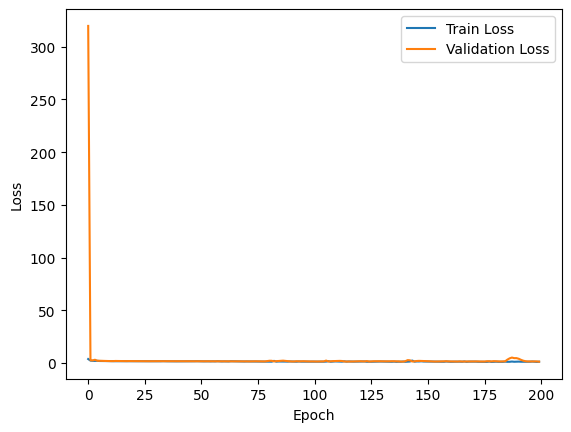

test...
Test Accuracy: 0.620384047267356
Micro F1: 0.620384047267356
Macro F1: 0.5780090691646149
Epoch: 0, LR: 0.5, Loss: 1.52355, Val Loss: 1.52355, Validation Accuracy: 0.6454948301329394
Epoch: 1, LR: 0.5, Loss: 1.28981, Val Loss: 1.28981, Validation Accuracy: 0.6189069423929099
Epoch: 2, LR: 0.5, Loss: 1.60065, Val Loss: 1.60065, Validation Accuracy: 0.5864106351550961
Epoch: 3, LR: 0.5, Loss: 1.41299, Val Loss: 1.41299, Validation Accuracy: 0.5790251107828656
Epoch: 4, LR: 0.5, Loss: 1.46248, Val Loss: 1.46248, Validation Accuracy: 0.5760709010339734
Epoch: 5, LR: 0.5, Loss: 1.23557, Val Loss: 1.23557, Validation Accuracy: 0.5775480059084195
Epoch: 6, LR: 0.5, Loss: 1.26334, Val Loss: 1.26334, Validation Accuracy: 0.5819793205317577
Epoch: 7, LR: 0.5, Loss: 1.27735, Val Loss: 1.27735, Validation Accuracy: 0.5672082717872969
Epoch: 8, LR: 0.5, Loss: 1.14708, Val Loss: 1.14708, Validation Accuracy: 0.5317577548005908
Epoch: 9, LR: 0.5, Loss: 2.08101, Val Loss: 2.08101, Validation A

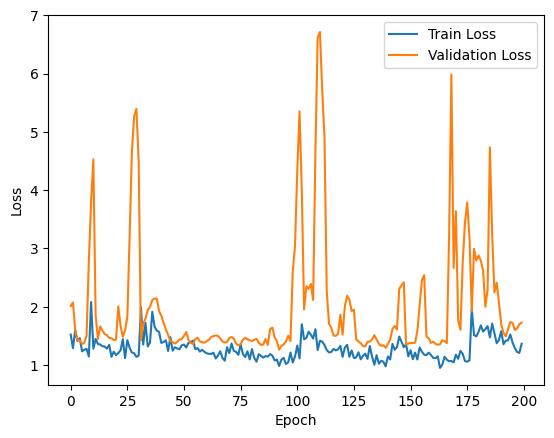

test...
Test Accuracy: 0.6484490398818316
Micro F1: 0.6484490398818316
Macro F1: 0.6087270146356282
Epoch: 0, LR: 0.5, Loss: 1.46867, Val Loss: 1.46867, Validation Accuracy: 0.6573116691285081
Epoch: 1, LR: 0.5, Loss: 1.32823, Val Loss: 1.32823, Validation Accuracy: 0.5937961595273265
Epoch: 2, LR: 0.5, Loss: 1.27382, Val Loss: 1.27382, Validation Accuracy: 0.5214180206794683
Epoch: 3, LR: 0.5, Loss: 1.33681, Val Loss: 1.33681, Validation Accuracy: 0.4874446085672083
Epoch: 4, LR: 0.5, Loss: 1.25911, Val Loss: 1.25911, Validation Accuracy: 0.47858197932053176
Epoch: 5, LR: 0.5, Loss: 1.36167, Val Loss: 1.36167, Validation Accuracy: 0.5361890694239291
Epoch: 6, LR: 0.5, Loss: 1.11492, Val Loss: 1.11492, Validation Accuracy: 0.5923190546528804
Epoch: 7, LR: 0.5, Loss: 1.30591, Val Loss: 1.30591, Validation Accuracy: 0.6129985228951256
Epoch: 8, LR: 0.5, Loss: 1.26453, Val Loss: 1.26453, Validation Accuracy: 0.6056129985228951
Epoch: 9, LR: 0.5, Loss: 1.26462, Val Loss: 1.26462, Validatio

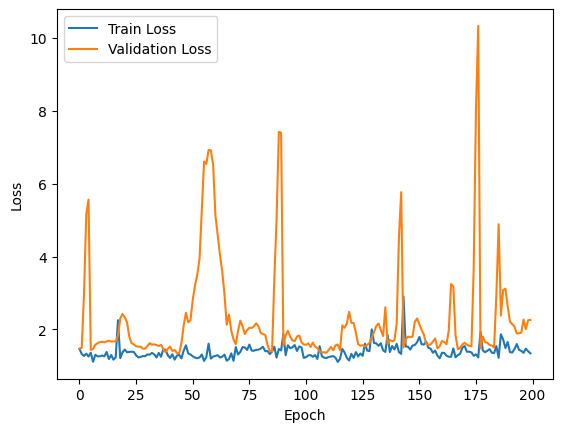

test...
Test Accuracy: 0.6484490398818316
Micro F1: 0.6484490398818316
Macro F1: 0.6087270146356282
Epoch: 0, LR: 0.5, Loss: 1.35135, Val Loss: 1.35135, Validation Accuracy: 0.6986706056129985
update best: 0.69867
Epoch: 1, LR: 0.5, Loss: 1.19954, Val Loss: 1.19954, Validation Accuracy: 0.654357459379616
Epoch: 2, LR: 0.5, Loss: 1.19867, Val Loss: 1.19867, Validation Accuracy: 0.6085672082717873
Epoch: 3, LR: 0.5, Loss: 1.27393, Val Loss: 1.27393, Validation Accuracy: 0.5332348596750369
Epoch: 4, LR: 0.5, Loss: 1.23452, Val Loss: 1.23452, Validation Accuracy: 0.4977843426883309
Epoch: 5, LR: 0.5, Loss: 1.28645, Val Loss: 1.28645, Validation Accuracy: 0.5273264401772526
Epoch: 6, LR: 0.5, Loss: 1.09254, Val Loss: 1.09254, Validation Accuracy: 0.5258493353028065
Epoch: 7, LR: 0.5, Loss: 1.41645, Val Loss: 1.41645, Validation Accuracy: 0.5125553914327917
Epoch: 8, LR: 0.5, Loss: 1.94172, Val Loss: 1.94172, Validation Accuracy: 0.5214180206794683
Epoch: 9, LR: 0.5, Loss: 1.21571, Val Loss:

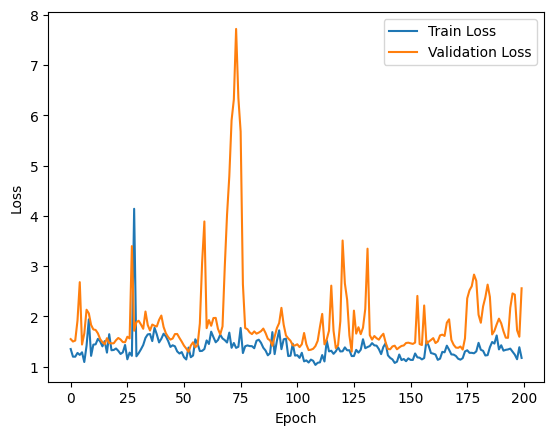

test...
Test Accuracy: 0.670605612998523
Micro F1: 0.670605612998523
Macro F1: 0.6434711484352346
Epoch: 0, LR: 0.5, Loss: 1.33085, Val Loss: 1.33085, Validation Accuracy: 0.689807976366322
Epoch: 1, LR: 0.5, Loss: 1.23183, Val Loss: 1.23183, Validation Accuracy: 0.6779911373707533
Epoch: 2, LR: 0.5, Loss: 1.24910, Val Loss: 1.24910, Validation Accuracy: 0.6440177252584933
Epoch: 3, LR: 0.5, Loss: 1.49781, Val Loss: 1.49781, Validation Accuracy: 0.5893648449039882
Epoch: 4, LR: 0.5, Loss: 1.23242, Val Loss: 1.23242, Validation Accuracy: 0.5480059084194978
Epoch: 5, LR: 0.5, Loss: 1.23503, Val Loss: 1.23503, Validation Accuracy: 0.5155096011816839
Epoch: 6, LR: 0.5, Loss: 1.11818, Val Loss: 1.11818, Validation Accuracy: 0.4963072378138848
Epoch: 7, LR: 0.5, Loss: 1.14592, Val Loss: 1.14592, Validation Accuracy: 0.4918759231905465
Epoch: 8, LR: 0.5, Loss: 1.15949, Val Loss: 1.15949, Validation Accuracy: 0.46971935007385524
Epoch: 9, LR: 0.5, Loss: 1.48763, Val Loss: 1.48763, Validation A

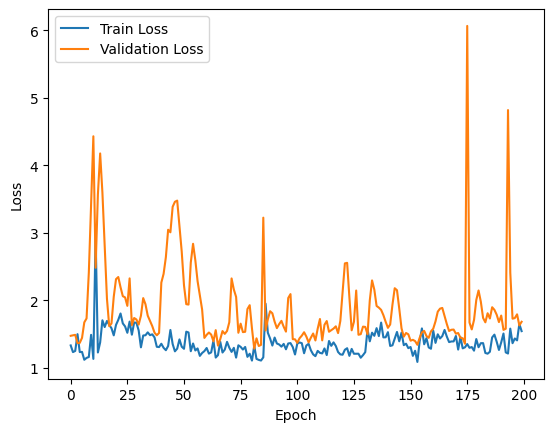

test...
Test Accuracy: 0.670605612998523
Micro F1: 0.670605612998523
Macro F1: 0.6434711484352346
test acc: 0.651698670605613 test acc std: 0.018529278322678578


test microf1: 0.651698670605613 test macrof1: 0.6164810790612681


In [115]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score

set_seed(42)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
evaluator = Evaluator(["accuracy", "f1_score", {"f1_score": {"average": "micro"}}])

model_unigin = UniGIN(X.shape[1], 256, cora_data["num_classes"], use_bn=True)
optimizer = optim.Adam(model_unigin.parameters(), lr=0.5, weight_decay=5e-4)

X, lbls = X.to(device), lbls.to(device)
G = G.to(device)
model_unigin = model_unigin.to(device)

best_state = None
best_epoch, best_val = 0, 0
num_epochs = 200
all_acc, all_microf1, all_macrof1 = [],[],[]
for run in range(5):

    train_losses = []  # 新增：用于存储每个epoch的train_loss
    val_losses = []  # 新增：用于存储每个epoch的val_loss
    for epoch in range(num_epochs):
        # train
        model_unigin.train()
        optimizer.zero_grad()
        outs = model_unigin(X,G)
        outs, lbl = outs[idx_train], lbls[idx_train]
        loss = F.cross_entropy(outs, lbl)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        # validation
        model_unigin.eval()
        with torch.no_grad():
            outs = model_unigin(X,G)
            outs, lbl = outs[idx_val], lbls[idx_val]
            val_loss = F.cross_entropy(outs, lbl)
            val_losses.append(val_loss)  # 新增：记录val_loss

            _, predicted = torch.max(outs, 1)
            correct = (predicted == lbl).sum().item()
            total = lbl.size(0)
            val_acc = correct / total
            print(f"Epoch: {epoch}, LR: {optimizer.param_groups[0]['lr']}, Loss: {loss.item():.5f}, Val Loss: {loss.item():.5f}, Validation Accuracy: {val_acc}")
            

            # Save the model if it has the best validation accuracy
            if val_acc > best_val:
                print(f"update best: {val_acc:.5f}")
                best_val = val_acc
                best_state = deepcopy(model_unigin.state_dict())
                torch.save(model_unigin.state_dict(), 'unigin_cocitationcora_best_model.pth')

    print("\ntrain finished!")
    print(f"best val: {best_val:.5f}")

    # 绘制曲线图
    plt.plot(range(num_epochs), train_losses, label='Train Loss')
    plt.plot(range(num_epochs), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # test
    print("test...")
    model_unigin.load_state_dict(best_state)

    model_unigin.eval()
    with torch.no_grad():
        outs = model_unigin(X, G)
        outs, lbl = outs[idx_test], lbls[idx_test]

        # Calculate accuracy
        _, predicted = torch.max(outs, 1)
        correct = (predicted == lbl).sum().item()
        total = lbl.size(0)
        test_acc = correct / total
        print(f'Test Accuracy: {test_acc}')

        # Calculate micro F1
        micro_f1 = f1_score(lbl.cpu(), predicted.cpu(), average='micro')
        print(f'Micro F1: {micro_f1}')

        # Calculate macro F1
        macro_f1 = f1_score(lbl.cpu(), predicted.cpu(), average='macro')
        print(f'Macro F1: {macro_f1}')

    all_acc.append(test_acc)
    all_microf1.append(micro_f1)
    all_macrof1.append(macro_f1)

# avg of 5 times
print('test acc:', np.mean(all_acc), 'test acc std:', np.std(all_acc))
print('\n')
print('test microf1:', np.mean(all_microf1), 'test macrof1:', np.mean(all_macrof1))